## Data calibration with 2 different dataset

In this code I will compare two datasets of the O3 sensors obtained with 2 different techniques: MLR and SVR.

I will compare the datasets with the values of the reference station, and I will approximate the dataset in order to get the best compression, based on the RMSE index.

In [96]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

def getReferData():
    sensor_data = "only-full-days.csv"

    timestamp_dataset = []
    refer_dataset = []
    mlr_dataset = []
    svr_dataset = []

    with open(sensor_data, "r") as dataset_file:
        reader = csv.reader(dataset_file)
        dataset = list(reader)
        index = 0
        for row in dataset:
            if index > 0: # and index < 25:
                timestamp_dataset.append(index)
                refer_dataset.append(float(row[1]))
                mlr_dataset.append(float(row[2]))
                svr_dataset.append(float(row[3]))
            index += 1
    
    return svr_dataset, mlr_dataset, refer_dataset

def getMatrix(dataset):
    X = np.empty((0, 24))

    index = 0
    for value in dataset:
        if index < 24*104:
            X = np.vstack([X, dataset[index:index+24]])
        else:
            break
        index+=24

    X=X.T
    return X

def calculate_rmse(X, Y):
    X, Y = np.array(X), np.array(Y)
    difference = X - Y
    squared_diff = difference**2
    mean_square_diff = np.mean(squared_diff)
    rmse = np.sqrt(mean_square_diff)
    print(f"RMSE = {rmse}")
    return rmse

def calculate_r2(X, Y):
    X, Y = np.array(X), np.array(Y)
    r2 = r2_score(X, Y)
    print(f"R2 = {r2}")
    return r2

def get_X_by_rank(REF, matrix, psi, rank):
    U, S, VT = np.linalg.svd(REF, full_matrices=False)
    U_k = U[:, :rank]

    new_matrix = np.empty((0,24))
    for vector in matrix.T:
        product = U_k@U_k.T@vector
        new_vector = psi + product
        new_matrix = np.vstack([new_matrix, new_vector])
    
    new_matrix = new_matrix.T
    return new_matrix

def myPlot(refer_dataset, mlr_dataset, svr_dataset):
    plt.figure(figsize=(15, 8))
    data = [200, 400, 800, 1200, 1600, 2000]

    # Generating x-values based on the length of the data list
    x = list(range(1, len(data) + 1))

    # Plotting the data with markers at data points
    plt.plot(refer_dataset, marker=".", linestyle="-", label="Reference", linewidth=0.5, color="blue")
    plt.plot(mlr_dataset, marker=".", linestyle="-", label="MLR", linewidth=0.5, color="green")
    plt.plot(svr_dataset, marker=".", linestyle="-", label="SVR", linewidth=0.5, color="red")


    # Set y-axis range and step
    plt.ylim(0, 250)  # Set the range of the y-axis from 0 to 3000
    plt.yticks(range(0, 250, 20))  # Set the y-axis ticks with a step of 100

    plt.legend()

    plt.xlabel("Index")
    plt.ylabel("Values (0-3000)")
    plt.title("Plotting a List of Values")

    plt.grid(True)
    plt.show()

Get datasets, delete the not complete days:

In [22]:
sensor_data = "data.csv"

timestamp_dataset = []
refer_dataset = []
mlr_dataset = []
svr_dataset = []
days_to_remove = []
with open(sensor_data, "r") as dataset_file:
    reader = csv.reader(dataset_file)
    dataset = list(reader)
    index = 0
    counter = 0
    days = 0
    current_date = "10/05/2017"
    diff = False
    for row in dataset:
        if index > 0: 
            date = row[0].split(' ')[0]

            if diff:
                # print(counter)
                if counter == 24:
                    days += 1
                else:
                    days_to_remove.append(current_date)

                counter = 1
                diff = False
                current_date = date

            if date == current_date:
                counter += 1
            else:
                diff = True

        index += 1

print(f"days to keep: {days}")

with open(sensor_data, "r") as dataset_file:
    reader = csv.reader(dataset_file)
    dataset = list(reader)
    index = 0
    for row in dataset:
        date = row[0].split(' ')[0]
        if not (date in days_to_remove):
            file = open("only-full-days.csv", "a")
            file.write(f"{str(row[0])}, {str(row[1])}, {str(row[2])}, {str(row[3])}\n")
            file.close()
        index +=1

days to keep: 104


I plot the data of the first day comparing all the datasets.

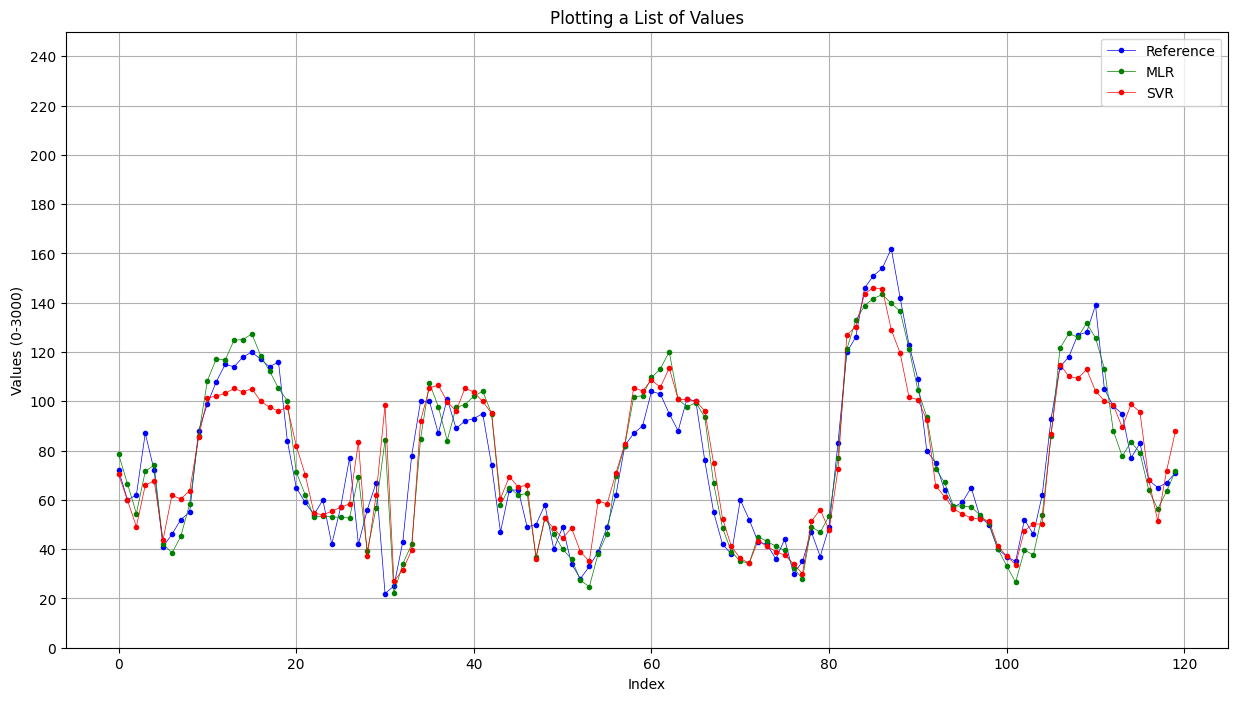

MLR:
RMSE = 13.440222065934652
R2 = 0.8762534223678156
SVR:
RMSE = 12.44653707621605
R2 = 0.8938750784307349


In [97]:
svr_dataset, mlr_dataset, refer_dataset = getReferData()

myPlot(refer_dataset[:24*5], mlr_dataset[:24*5], svr_dataset[:24*5])
print("MLR:")
rmse = calculate_rmse(refer_dataset, mlr_dataset)
r_2 = calculate_r2(refer_dataset, mlr_dataset)
print("SVR:")
rmse = calculate_rmse(refer_dataset, svr_dataset)
r_2 = calculate_r2(refer_dataset, svr_dataset)


## Get the best RMSE approximation
I define the function that I will use in both cases:

In [89]:
def getListValue(matrix):
    new_list = []
    i = 0
    for row in matrix.T:
        row = row.tolist()
        for item in row:
            new_list.append(item)
        i+=1
    return new_list

def plot_rmse_approximation(my_dataset):
    X = getMatrix(refer_dataset)
    Y = getMatrix(my_dataset)

    ref_matrix = X

    psi = np.mean(X, axis=1)

    # normalization of svr dataset
    newY = np.empty((0, 24))
    for y in Y.T:
        newY = np.vstack([newY, np.subtract(y, psi)])

    Y = newY.T

    # normalization of ref data
    newX = np.empty((0, 24))
    for x in X.T:
        newX = np.vstack([newX, np.subtract(x, psi)])

    X = newX.T

    ranks = []
    rmse_values = []
    min = 1000
    rank_min = 0
    for r in range(1, 25):
        newX = get_X_by_rank(X, Y, psi, r)
        rmse = calculate_rmse(ref_matrix, newX)
        if rmse < min:
            rank_min = r
            min = rmse
        ranks.append(r)
        rmse_values.append(rmse)

    plt.figure(figsize=(10, 8))  # Adjust figure size if needed
    plt.plot(ranks, rmse_values, marker='o', linestyle='-', label='RMSE approximation')
    plt.axhline(y=min, color='r', linestyle='--', label='Minimum RMSE')
    plt.text(15, min - 0.1, f'min = {min:.4f}', color='r')
    plt.plot(rank_min, min, marker='o', linestyle='', color='red')

    # Customize the plot
    plt.legend()
    plt.title('RMSE based on the subspace rank')
    plt.xlabel('Rank of Subspace')
    plt.ylabel('RMSE')
    plt.grid(True)
    plt.xticks(ranks)  # Show all ranks on x-axis

    plt.show()

    r2_values = []
    max_r2 = 0
    for r in range(1, 25):
        newX = get_X_by_rank(X, Y, psi, r)
        new_dataset = getListValue(newX)
        r2 = r2_score(refer_dataset[:len(new_dataset)], new_dataset)
        r2_values.append(r2)
        if max_r2 < r2:
            max_r2 = r2

    plt.figure(figsize=(10, 8))  # Adjust figure size if needed
    plt.plot(ranks, r2_values, marker='o', linestyle='-', label='R-squared')
    plt.axhline(y=max_r2, color='r', linestyle='--', label='Highest R-squared')
    plt.text(15, max_r2 + 0.001, f'R-squared = {max_r2:.4f}', color='r')
    plt.plot(rank_min, max_r2, marker='o', linestyle='', color='red')

    # Customize the plot
    plt.legend()
    plt.title('R-squared based on the subspace rank')
    plt.xlabel('Rank of Subspace')
    plt.ylabel('R-squared')
    plt.grid(True)
    plt.xticks(ranks)  # Show all ranks on x-axis

    plt.show()

    return X, Y, psi, rank_min



Let's start with the SVR dataset

RMSE = 15.36457709968718
RMSE = 13.112793482045259
RMSE = 12.290276440059005
RMSE = 11.997438964728495
RMSE = 11.67783046196783
RMSE = 11.483350907872083
RMSE = 11.425879385339417
RMSE = 11.389867474891268
RMSE = 11.544895361003073
RMSE = 11.572136658971377
RMSE = 11.677439903498056
RMSE = 11.740227200084146
RMSE = 11.784560656896671
RMSE = 11.825831353494749
RMSE = 11.846436964639365
RMSE = 11.957168777738419
RMSE = 12.021034839700247
RMSE = 12.101407132502596
RMSE = 12.180324864013032
RMSE = 12.247372860656206
RMSE = 12.31567396507072
RMSE = 12.358885506926656
RMSE = 12.410415946663495
RMSE = 12.454532376719586


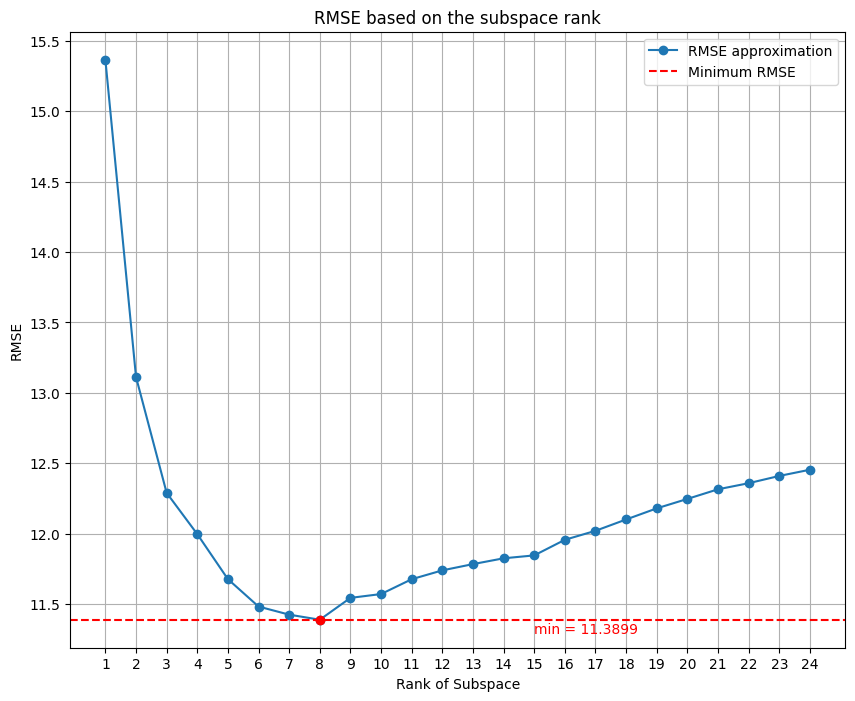

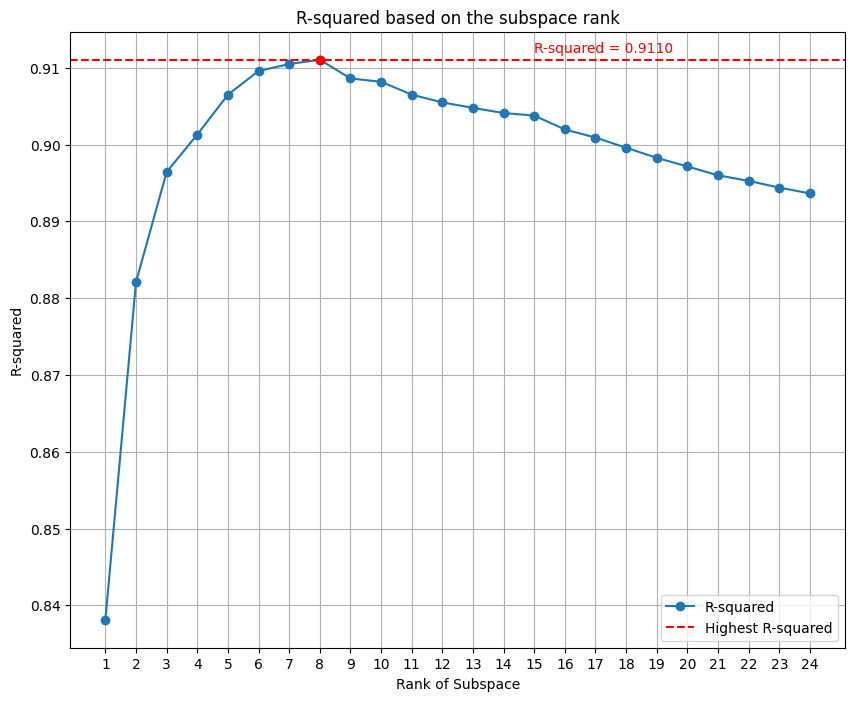

In [90]:
X, Y, psi, rank_min = plot_rmse_approximation(svr_dataset)

Now I will plot the denoised data, using the RMSE approximation

In [91]:
def getListValueToPlot(matrix):
    new_list = []
    i = 0
    for row in matrix.T:
        if i < 104:
            row = row.tolist()
            for item in row:
                new_list.append(item)
            i+=1
        else:
            break
    return new_list

def plot_denoised_signal(X, Y, psi, rank_min):
    newX = get_X_by_rank(X, Y, psi, rank_min)
    newList = getListValueToPlot(newX)

    # data_to_plot = refer_dataset

    # I plot the first 5 days
    data_to_plot = refer_dataset[:24*5]

    plt.figure(figsize=(10, 8))  # Adjust figure size if needed
    plt.plot(newList[:24*5], marker=".", linestyle="-", label="Denoised", linewidth=0.5, color="red")
    plt.plot(data_to_plot, marker=".", linestyle="-", label="Original", linewidth=0.5, color="blue")

    # Customize the plot
    plt.title('Denoised results')
    plt.xlabel('Samples')
    plt.ylabel('Sensor values')
    plt.grid(True)
    plt.legend()

    plt.show()

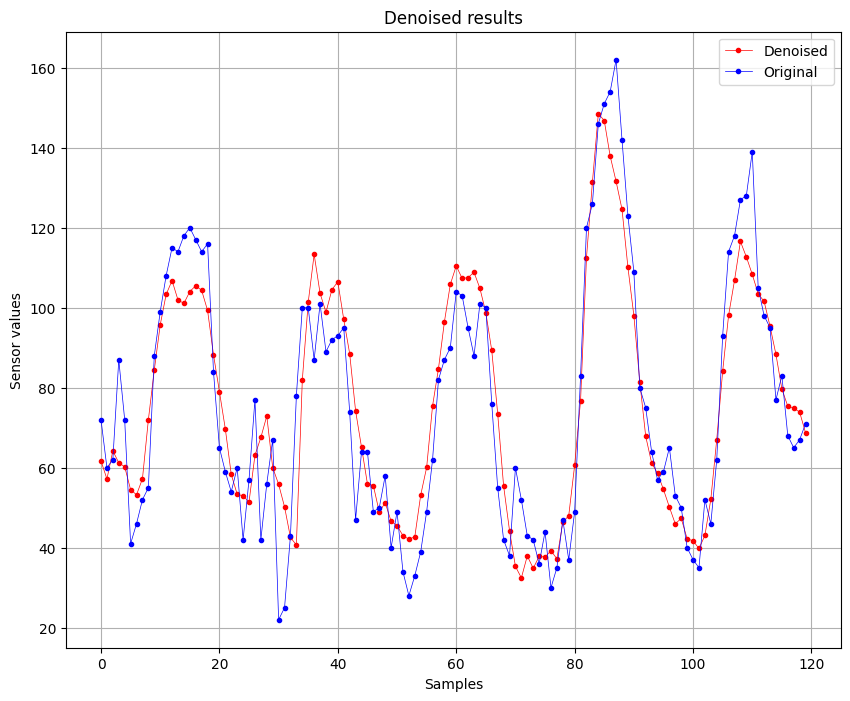

In [92]:
plot_denoised_signal(X, Y, psi, rank_min)

And repetat the same for MLR dataset

RMSE = 15.846004473651803
RMSE = 14.55050629167466
RMSE = 13.85057685929258
RMSE = 13.540760804646418
RMSE = 13.264283355422652
RMSE = 13.105566296545458
RMSE = 13.048196598268735
RMSE = 12.991356989093228
RMSE = 12.984260126445802
RMSE = 12.977429353065009
RMSE = 13.018873109908245
RMSE = 13.073785539564408
RMSE = 13.084360929024351
RMSE = 13.115343438520355
RMSE = 13.123905445981793
RMSE = 13.187569769106604
RMSE = 13.213888495028407
RMSE = 13.24982276814856
RMSE = 13.275924938562522
RMSE = 13.31118672922716
RMSE = 13.348519173661185
RMSE = 13.376760353594136
RMSE = 13.404148148793992
RMSE = 13.424000047811896


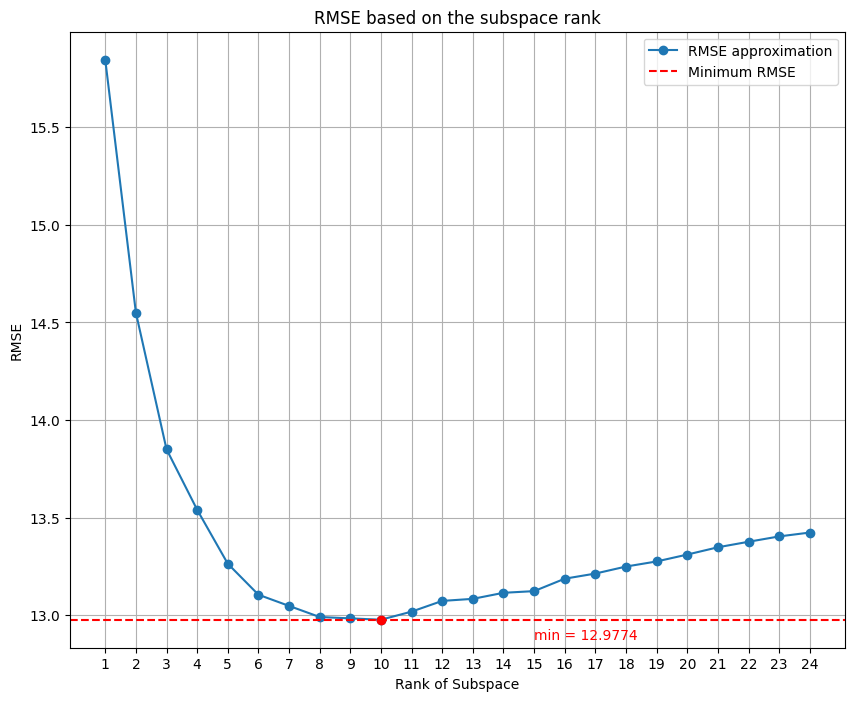

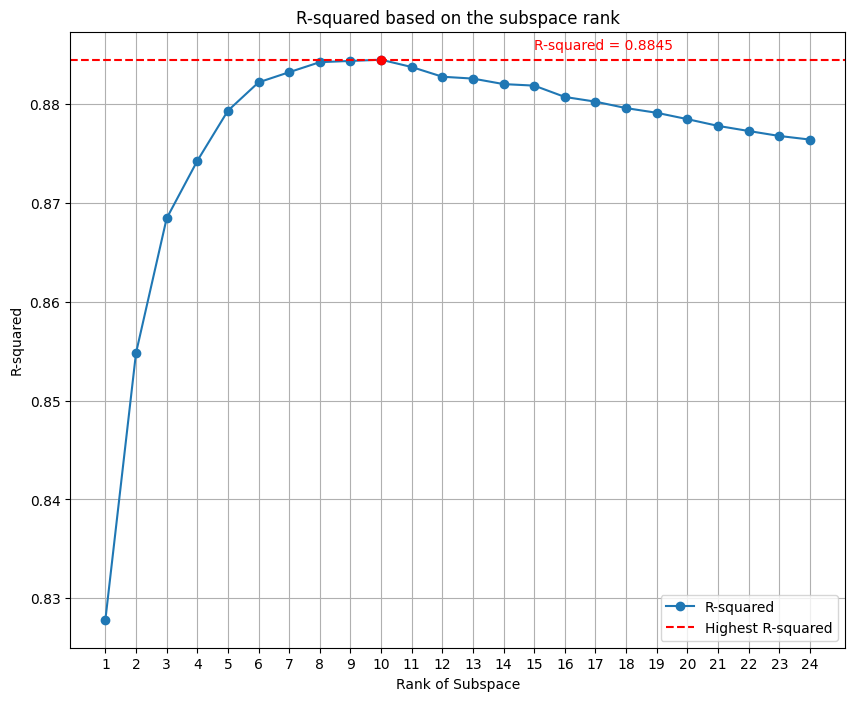

In [93]:
X, Y, psi, rank_min = plot_rmse_approximation(mlr_dataset)

Now I will plot the denoised data, using the RMSE approximation

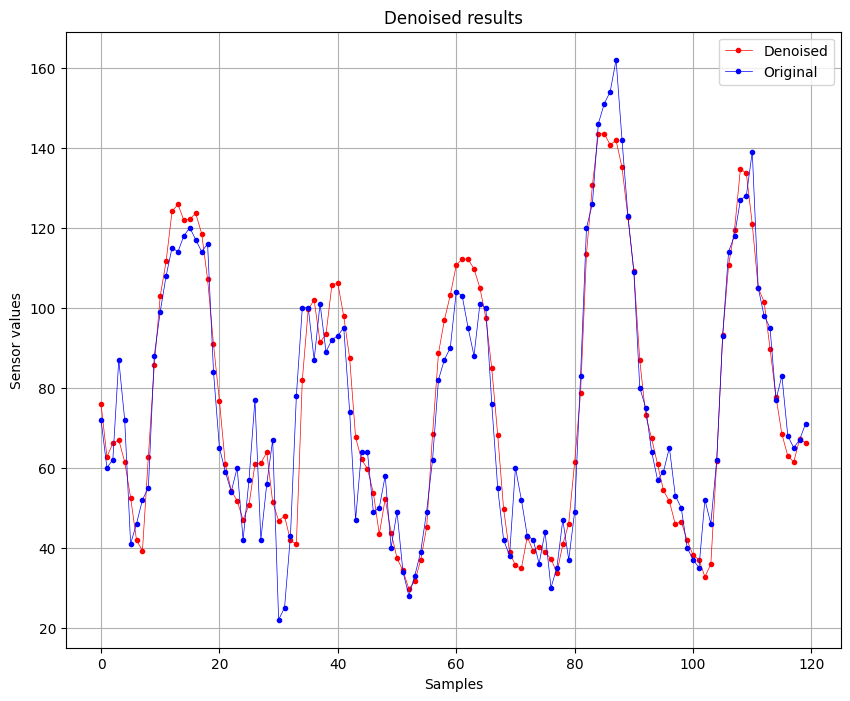

In [94]:
plot_denoised_signal(X, Y, psi, rank_min)

## Gavish et. al method for approximation

Now I try to get another approximation without using the reference station as a reference for the approximation, but I use the Gavish et. al method.

In [109]:
def plot_gavish_method(my_dataset):
    Y = getMatrix(my_dataset)
    U, S, VT = np.linalg.svd(Y)

    median = np.median(S)
    print(f"median = {median}")

    beta = 24/104
    omega = 0.56*(beta**3)-0.95*(beta**2)+1.82*beta+1.43
    print(f"omega = {omega}")
    sigma = omega*median
    print(f"sigma = {sigma}")

    rank = np.sum(S > sigma)
    print(f"the rank is = {rank}")

    kappa = np.max(S) / np.min(S)
    print(f"Kappa (κ) value calculated: {kappa}\n")
    ranks = [*range(1,25)]

    psi = np.mean(Y, axis=1)
    newY = np.empty((0, 24))
    for y in Y.T:
        newY = np.vstack([newY, np.subtract(y, psi)])

    Y = newY.T

    rmse_values = []
    min = 1000
    rank_min = 0
    for r in range(1, 25):
        newY = get_X_by_rank(X, Y, psi, r)
        rmse = calculate_rmse(X, newY)
        if r == 7:
            rank_min = r
            min = rmse
        rmse_values.append(rmse)
    
    plt.figure(figsize=(12, 8))
    plt.axhline(y=sigma, color='r', linestyle='--', label='Threshold')
    plt.plot(ranks, S, marker='o', linestyle='dotted')

    plt.plot([i for i in range(1, rank+1)], 
            [val for val in S if val > sigma], 
            marker='o', linestyle='', color='red', label=f'Values above threshold ({sigma:.4f})')

    plt.yscale("log")
    plt.legend()
    plt.grid(True)
    plt.title('Singular Values MLR')
    plt.xlabel('Rank')
    plt.ylabel('Singular Values')
    plt.xticks(ranks)  # Show all ranks on x-axis
    plt.show()

    plt.figure(figsize=(10, 8))  # Adjust figure size if needed
    plt.plot(ranks, rmse_values, marker='o', linestyle='-', label='RMSE approximation')
    plt.axhline(y=min, color='r', linestyle='--', label='RMSE on rank 7')
    plt.text(15, min + 0.01, f'{min:.4f}', color='r')
    # plt.ylim(11.85, 13)
    plt.plot(rank_min, min, marker='o', linestyle='', color='red')

    plt.legend()
    plt.title('RMSE based on the subspace rank')
    plt.xlabel('Rank of Subspace')
    plt.ylabel('RMSE')
    plt.grid(True)
    plt.xticks(ranks)  # Show all ranks on x-axis
    plt.show()

    newX = get_X_by_rank(X, Y, psi, rank_min)
    newList = getListValue(newX)[:24*5]

    data_to_plot = refer_dataset[:24*5]

    plt.figure(figsize=(10, 8))  # Adjust figure size if needed
    plt.plot(newList, marker=".", linestyle="-", label="Denoised", linewidth=0.5, color="red")
    plt.plot(data_to_plot, marker=".", linestyle="-", label="Original", linewidth=0.5, color="blue")

    # Customize the plot
    plt.title('Denoised results')
    plt.xlabel('Samples')
    plt.ylabel('Sensor values')
    plt.grid(True)
    plt.legend()

    plt.show()

Let's start with the SVR dataset:

median = 78.01156769251858
omega = 1.806290395994538
sigma = 140.9115454994741
the rank is = 7
Kappa (κ) value calculated: 160937.8048402746

RMSE = 84.37617099919811
RMSE = 83.9945675878331
RMSE = 83.8331285256875
RMSE = 83.7701262083108
RMSE = 83.72428181955388
RMSE = 83.69673130016265
RMSE = 83.68444067497516
RMSE = 83.67916782989457
RMSE = 83.69976348172516
RMSE = 83.70342899961821
RMSE = 83.71484594183542
RMSE = 83.7232905668506
RMSE = 83.72950323452557
RMSE = 83.73479453275303
RMSE = 83.73761699467327
RMSE = 83.75128270416175
RMSE = 83.75993972438123
RMSE = 83.77123481601085
RMSE = 83.7819300389434
RMSE = 83.79162681006694
RMSE = 83.80159967719385
RMSE = 83.80742096203453
RMSE = 83.81493090665347
RMSE = 83.82126891285775


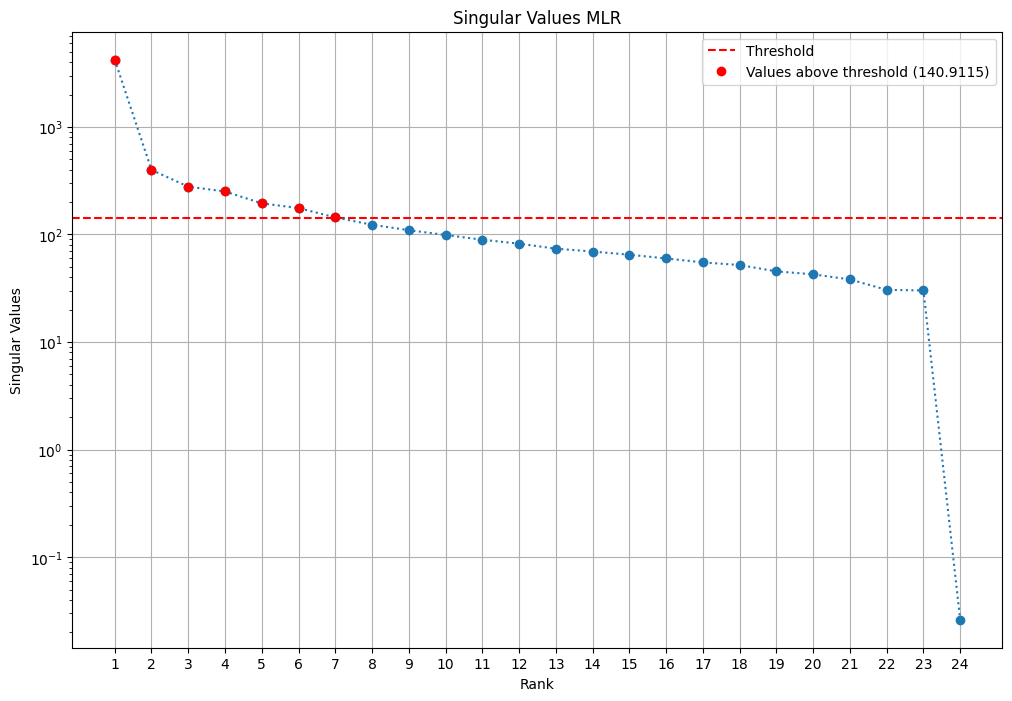

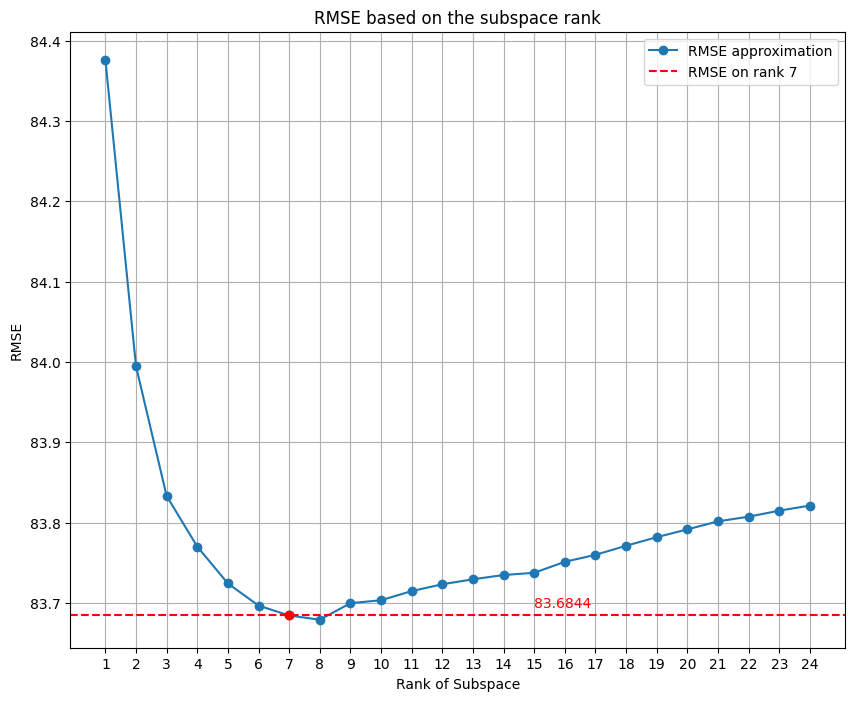

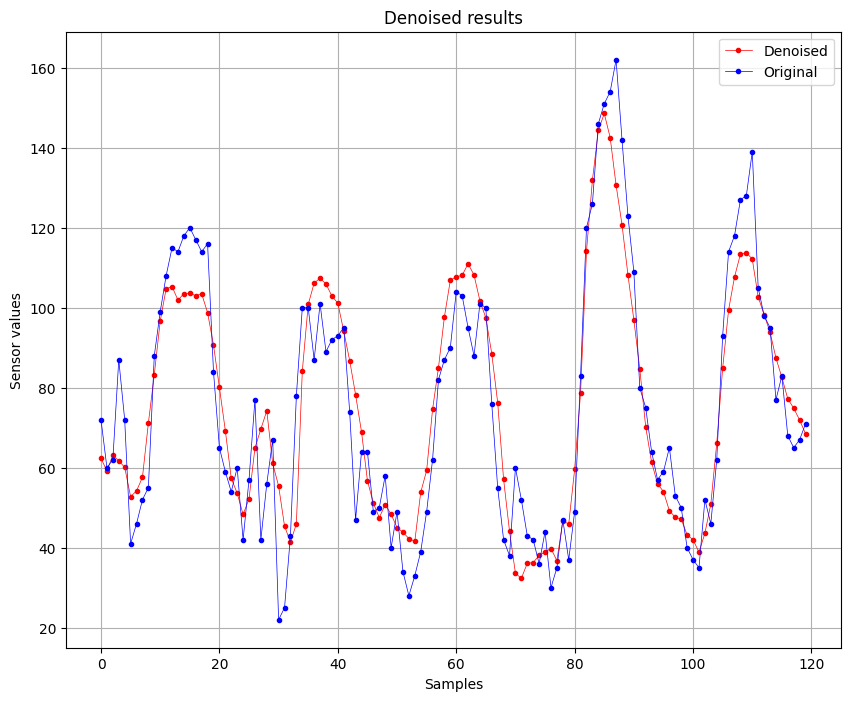

In [110]:
plot_gavish_method(svr_dataset)

Now, with the MLR dataset:

median = 58.660738632060585
omega = 1.806290395994538
sigma = 105.95832881303681
the rank is = 7
Kappa (κ) value calculated: 137939.29224476343

RMSE = 84.10928732098478
RMSE = 83.83728678594623
RMSE = 83.67973102885053
RMSE = 83.60342972350237
RMSE = 83.5541118916373
RMSE = 83.52246619851638
RMSE = 83.50842412105631
RMSE = 83.49934446057621
RMSE = 83.49809148936174
RMSE = 83.49638509912161
RMSE = 83.50011791516326
RMSE = 83.50661566308048
RMSE = 83.50819255104638
RMSE = 83.51304809871962
RMSE = 83.5142013611319
RMSE = 83.52101399517511
RMSE = 83.52459162374565
RMSE = 83.52992847768678
RMSE = 83.53354136435416
RMSE = 83.53903260770733
RMSE = 83.54483793198129
RMSE = 83.54893867183513
RMSE = 83.55326935535287
RMSE = 83.55629962183262


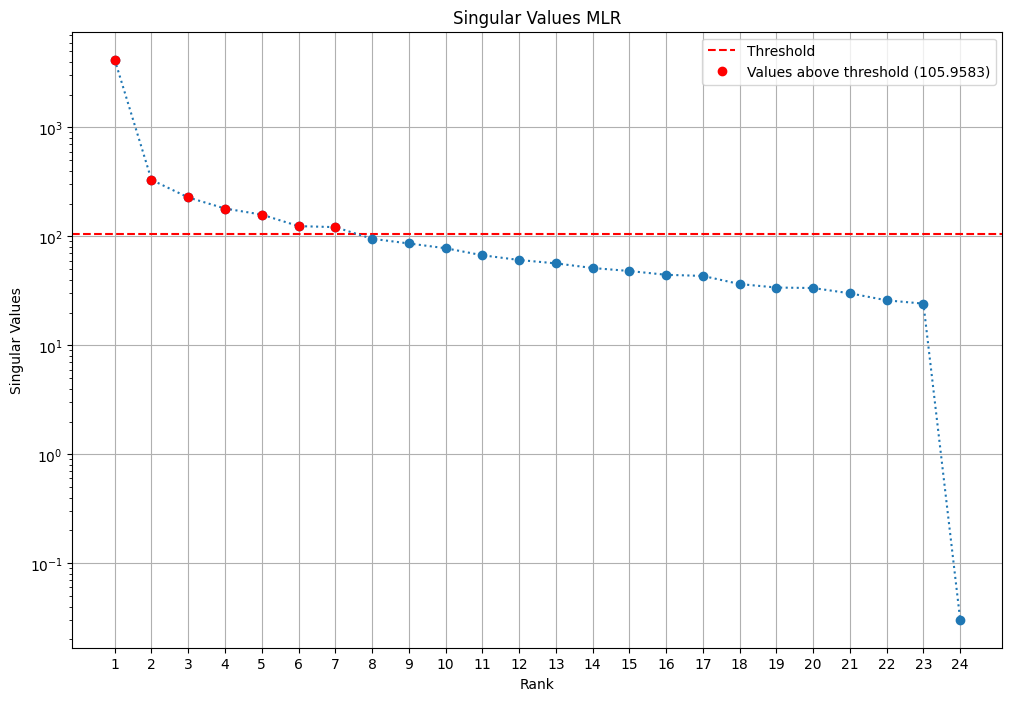

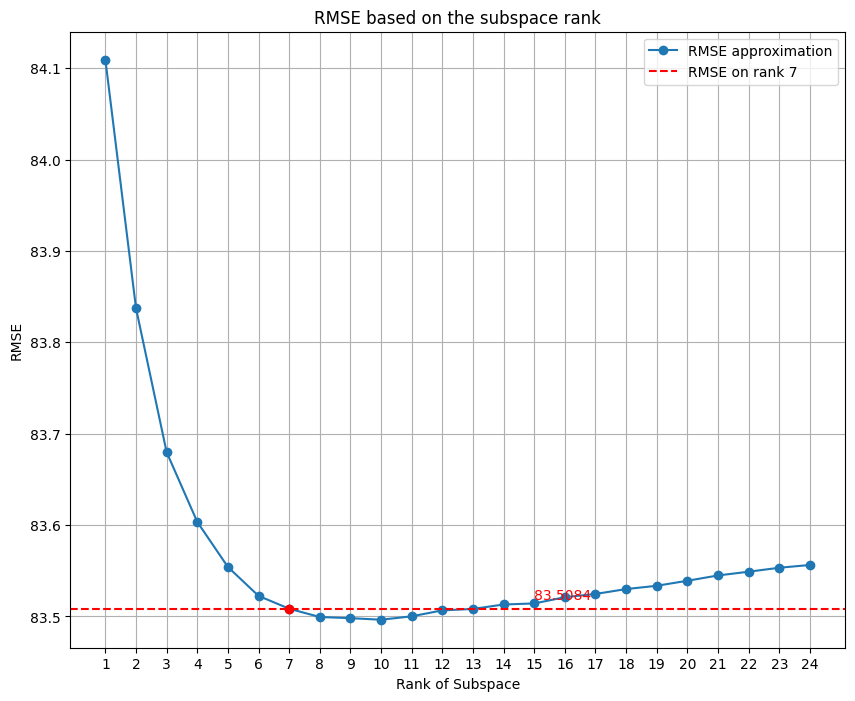

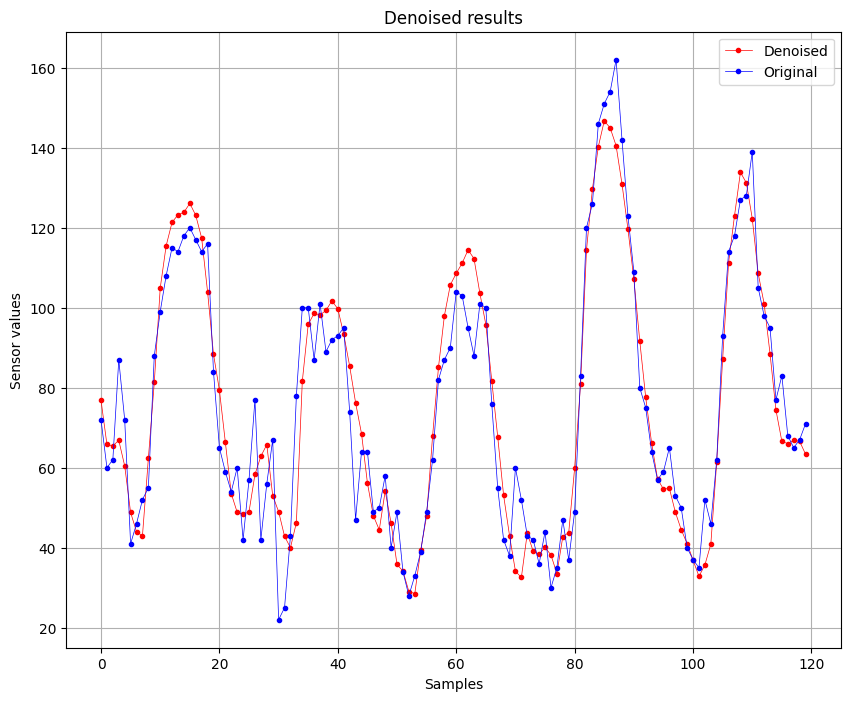

In [112]:
plot_gavish_method(mlr_dataset)